### In this notebook, we will explore the following questions: 
 - Is there a relationship between the number of installs and the number of user ratings? 
     - We predict that this is true: although not every user rates an app, if a particular proportion of users do, then more downloads (more users) should yield more user ratings. 
 - Are apps getting better? More specifically, are the ratings and the number of reviews higher for newer apps? 
     - We also predict this to be true because phones have, admittedly, become more ubiquitous over the years.    
     
 - ##### Are there trends in the number of user ratings for each developer? (Namely, if a developer publishes a "popular" app, do their subsequent apps become more popular due to the increased recognition/exposure?)

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
import re

In [2]:
sns.set()

In [3]:
apps = pd.read_csv('googleplaystore.csv')
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
# Drop invalid entry and irrelevant columns to current analysis
apps.drop(columns=['Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
apps = apps[apps['Installs'] != 'Free']

In [5]:
# Remove the '+' at the end of the Installs entry so they can be numerically sorted 
# Also remove the ',' separating the numbers
apps['Installations'] = apps['Installs'].str.replace(r'\+|,', '')
apps['Installations'] = apps['Installations'].astype(int)
apps['Reviews'] = apps['Reviews'].astype(int)

<ipython-input-5-398abf95c79c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  apps['Installations'] = apps['Installs'].str.replace(r'\+|,', '')


##### Since installs are grouped into 'n+', let's visualize the number of apps in each bracket

In [6]:
grouped_installs = apps.groupby(by=['Installs', 'Installations']).count()
 
grouped_installs.reset_index(inplace=True)

In [7]:
grouped_installs.sort_values(by=['Installations'], inplace=True)

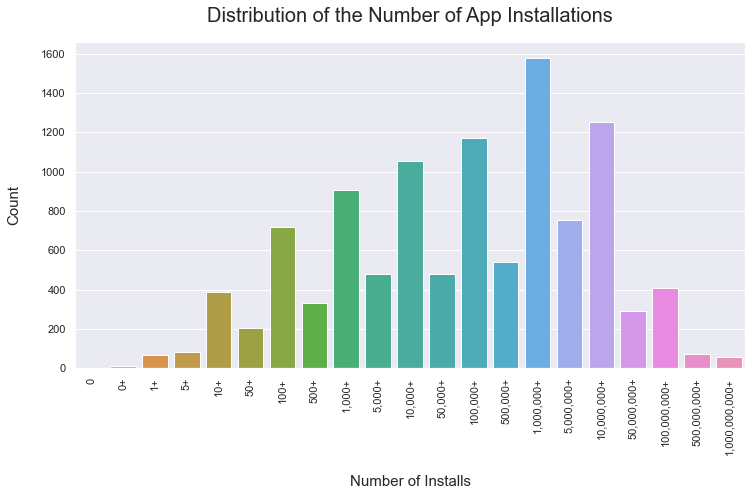

In [8]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
sns.barplot(x='Installs', y='App', data=grouped_installs)
plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of App Installations', fontsize=20, pad=20)
plt.xticks(rotation=90)
plt.show()

We suppose that (virtually) all apps have at least one install because its own developer would presumbly install it themselves for testing purposes. Although it is interesting to note that, despite the increasing interval size (we do not have access to the exact number of installs from the data), there is no evident monotonically increasing or decreasing trend. We thought that, as a consequence of the invervals increasing in size, a larger interval could "cover" more apps, so there would be an increasing trend. But we can observe that the number of apps in each 'bucket' alternates between increasing and decreasing from 5+ to 5,000,000+.

Since the dataset is large, to first visualize a scatterplot of the number of reviews against the number of installations, we wil sample the data

In [9]:
sample = apps.sample(500, random_state=35)

# Sort by Installations so the xticks will be in increasing order
sample.sort_values(by=['Installations'], inplace=True)

In [10]:
def plot_installs_and_reviews(sample, show=True):
    figure = plt.figure(figsize=(12, 6))
    axis = plt.gca()
    # From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
    axis.ticklabel_format(style='plain')

    sns.scatterplot(x=sample['Installs'], y=sample['Reviews'], data=sample)
    plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
    plt.ylabel('Number of Reviews', fontsize=15, labelpad=20)
    plt.title('Number of Reviews Against the Number of Installs for Apps', fontsize=20, pad=20)
    plt.xticks(rotation=90)

    if show: 
        plt.show()

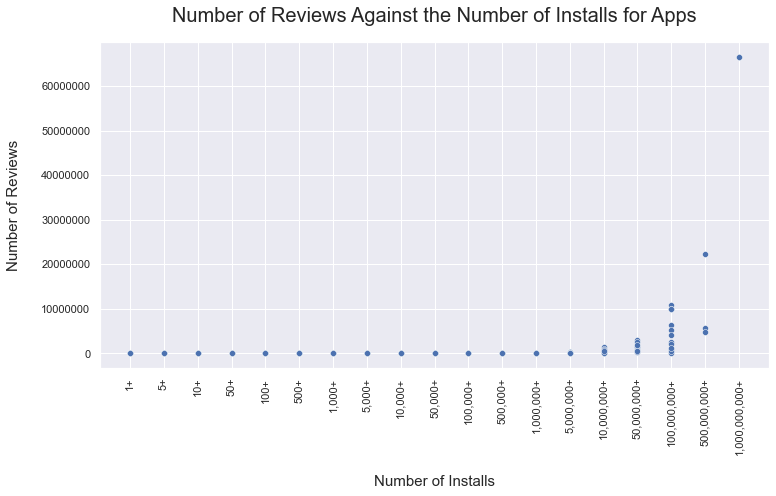

In [11]:
plot_installs_and_reviews(sample)

There appears to be an outlier. Possibly two. Let's remove them and proceed to fit a best-fit line. 

In [12]:
# From https://stackoverflow.com/questions/35087539/drop-pandas-dataframe-row-based-on-max-value-of-a-column
sample.drop(sample['Reviews'].idxmax(), inplace=True)
sample.drop(sample['Reviews'].idxmax(), inplace=True)

fit = stats.linregress(sample['Installations'], sample['Reviews'])
sample['prediction'] = sample['Installations']*fit.slope + fit.intercept

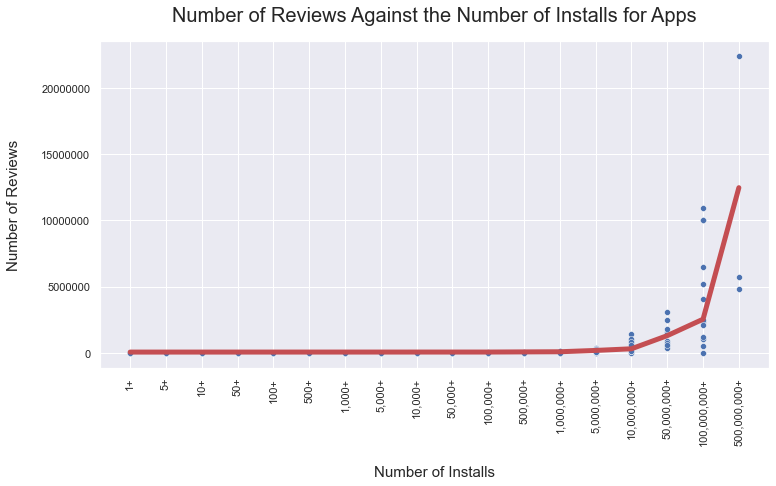

In [13]:
plot_installs_and_reviews(sample, show=False)
plt.plot('Installs', 'prediction', data=sample, color='r', linewidth=5)
plt.show()

In [14]:
fit.pvalue

1.1706519236030766e-88

With a pvalue of 1.1706519236030766e-88, we can strongly reject the null hypothesis that the slope is 0 and conclude that more installs is linearly associated with more reviews. 

But the best-fit does not seem to visually increase until the number of installs goes past one million. Let's repeat this experiment when the number of installs is less than one million. 

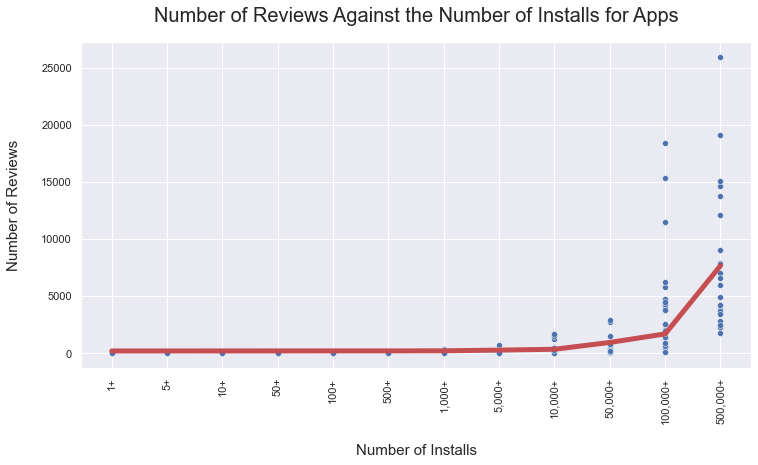

In [15]:
sample = sample[sample['Installations'] < 1000000]

fit = stats.linregress(sample['Installations'], sample['Reviews'])
sample['prediction'] = sample['Installations']*fit.slope + fit.intercept

plot_installs_and_reviews(sample, show=False)
plt.plot('Installs', 'prediction', data=sample, color='r', linewidth=5)
plt.show()

In [16]:
fit.pvalue

6.039759952387762e-40

The p-value is extremely tiny: 6.039759952387762e-40. Again, even when we only consider apps that have less than one million installs, we still observe a linear association between the number of installs and the number of reviews. 

Next, we return to the original data set and compute a correlation coefficient. 

In [17]:
r, p_value= stats.pearsonr(apps['Reviews'], apps['Installations'])
r, p_value

(0.6431220683230671, 0.0)

With a p-value is 0, we know that the probability of observing the given results if the correlation coefficient was actually 0, is virtually 0. Certainly, there exists a positive linear association between the number of installs and the number of reviews. 

To investigate our next question: Are the number of app ratings increasing for newer apps?, we turn to 'appstore_games.csv', a dataset that includes mobile strategy games.

In [18]:
strategy_game_apps = pd.read_csv('appstore_games.csv')

In [19]:
strategy_game_apps.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [20]:
# Drop columns that are not relevant to current analysis 
strategy_game_apps = strategy_game_apps.drop(columns=['URL', 'Subtitle', 'Icon URL', 'In-app Purchases', 'Description', 'Current Version Release Date'])
strategy_game_apps = strategy_game_apps.dropna()
strategy_game_apps.drop_duplicates(inplace=True)

In [21]:
strategy_game_apps['Original Release Date'] = pd.to_datetime(strategy_game_apps['Original Release Date'])

In [22]:
# Sort by Release Date to retain this order for subsequent aggregate
strategy_game_apps.sort_values(by=['Original Release Date'], inplace=True)
strategy_game_apps['Original Release Date'] = strategy_game_apps['Original Release Date'].astype(str)
strategy_game_apps

,ID,Name,Average User Rating,User Rating Count,Price,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date
9,286682679,"""Barrels O' Fun""",2.5,184.0,0.00,BesqWare,4+,EN,1466515.0,Games,"Games, Casual, Strategy",2008-01-08
17,289382458,Chess Game,3.0,504.0,0.00,Memention Holding AB,4+,EN,444163.0,Games,"Games, Board, Strategy",2008-02-09
25,292274288,Gaia Lite,3.5,1563.0,0.00,Quicksand Interactive,4+,EN,6550985.0,Games,"Games, Strategy, Puzzle",2008-02-10
7,286363959,Colony,2.5,125.0,0.99,Chris Haynes,4+,EN,64333824.0,Games,"Games, Strategy, Board",2008-03-08
8,286566987,Carte,2.5,44.0,0.00,Jean-Francois Pautex,4+,FR,2657280.0,Games,"Games, Strategy, Board, Entertainment",2008-03-08
...,...,...,...,...,...,...,...,...,...,...,...,...
16451,1459381560,Weather Battle,4.0,15.0,0.00,Weather Battle LLC,17+,EN,28974080.0,Games,"Games, Trivia, Strategy, Entertainment",2019-12-04
16096,1452148065,Sport Car Driving: City Advent,3.0,97.0,0.00,MAI THI HUONG,4+,EN,344571904.0,Games,"Games, Strategy, Entertainment, Racing",2019-12-05
16589,1463219987,Quiz For Robux Pro Guide,4.5,29.0,0.00,Abdeslam Ghanem,4+,EN,56589312.0,Games,"Games, Reference, Trivia, Strategy",2019-12-05
15257,1437953817,Paragon Kingdom: Arena,4.5,6.0,0.00,Nexus Media Ltd,9+,EN,161506304.0,Games,"Games, Strategy, Action",2019-12-06


In [23]:
pattern = re.compile('^(\d{4}-\d{2})-\d{2}$')
def extract_month_and_year(date): 
    match = pattern.match(date)
    if match: 
        return match[1]
    else:
        return np.nan 

In [24]:
# 'Remove' the day so we can group by the month, otherwise we will have too many data points. 
strategy_game_apps['Release Month/Year'] = strategy_game_apps['Original Release Date'].apply(lambda x: extract_month_and_year(x))

In [25]:
grouped_dates = strategy_game_apps.groupby(by=['Release Month/Year'])
average_rating = grouped_dates.mean('Average User Rating').reset_index()
average_num_ratings = grouped_dates.mean('User Rating Count').reset_index()

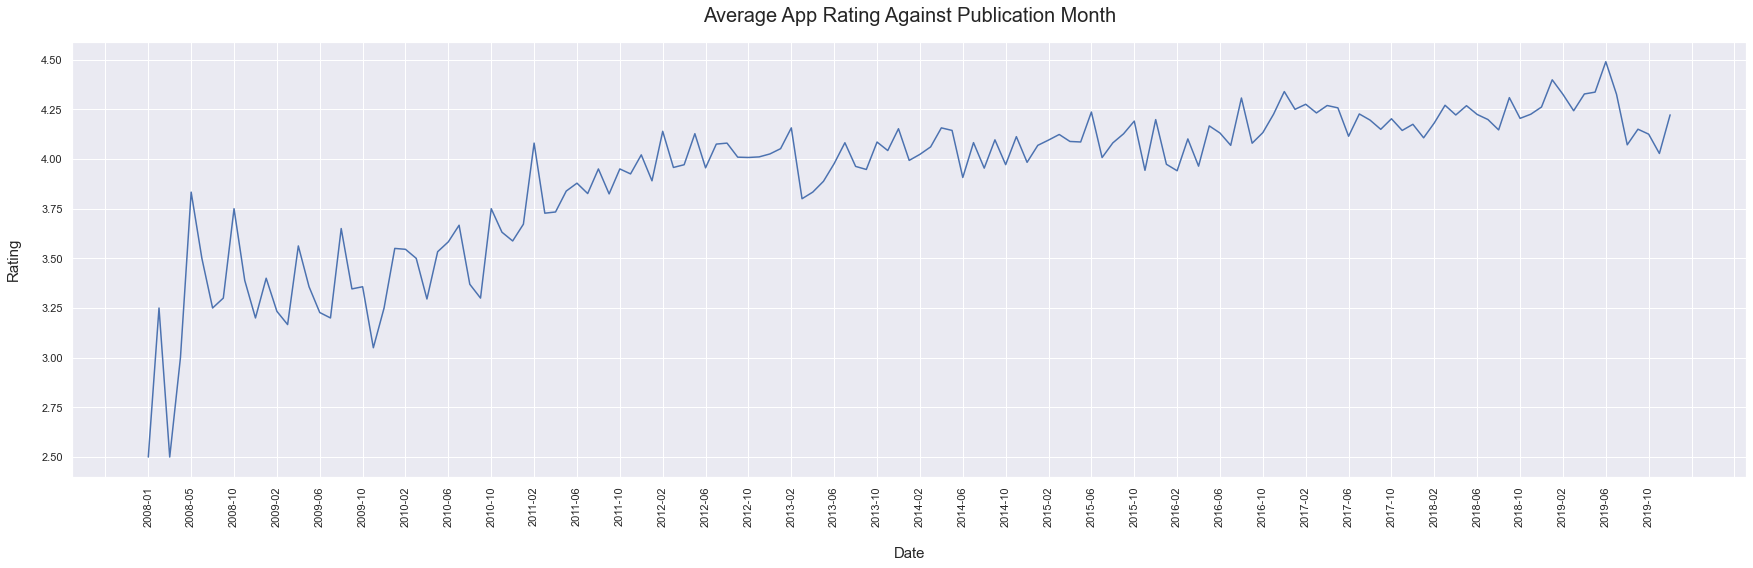

In [26]:
figure = plt.figure(figsize=(30, 8))
axis = plt.gca()
plt.plot(average_rating['Release Month/Year'], average_rating['Average User Rating'])
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Rating', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Average App Rating Against Publication Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

In [27]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

You should consider upgrading via the '/Users/allanche/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the rating of apps. 

Null hypothesis: There does not exist an increasing or decreasing trend 

Alternative hypothesis: There does exist an increasing or decreasing trend

In [28]:
# Inspired from https://pypi.org/project/pymannkendall/
import pymannkendall as mk

trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(average_rating['Average User Rating'])
trend, pvalue

('increasing', 0.0)

Indubitably, from the test, we can reject the null hypothesis and conclude that there does exist a trend in the number of app ratings -- particularly an increasing one. 

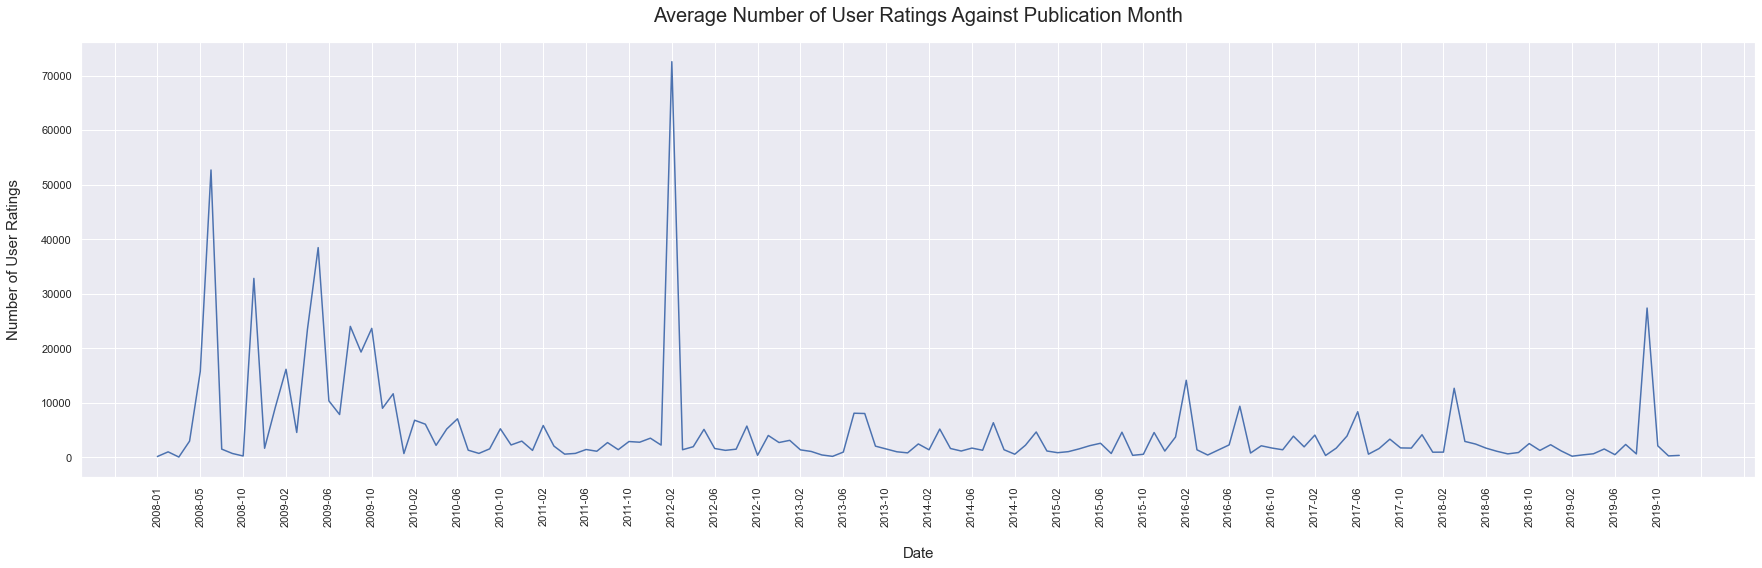

In [29]:
figure = plt.figure(figsize=(30, 8))
axis = plt.gca()
plt.plot(average_num_ratings['Release Month/Year'], average_num_ratings['User Rating Count'])
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Average Number of User Ratings Against Publication Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

Apps published in February of 2012 have an unusally large number of user ratings. Let's investigate that data point. 

In [30]:
high_num_ratings = strategy_game_apps[strategy_game_apps['Release Month/Year'] == '2012-02'].copy()
high_num_ratings.sort_values(by=['User Rating Count'], ascending=False, inplace=True)

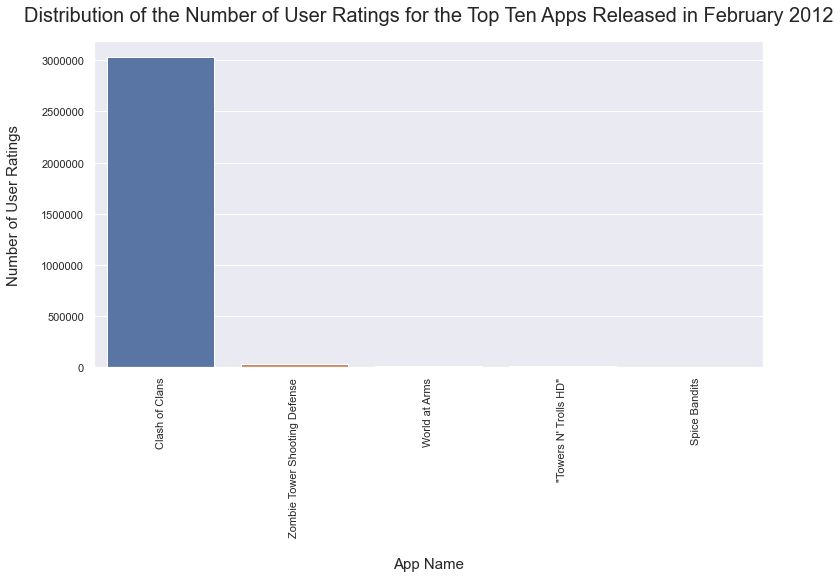

In [31]:
top_ten = high_num_ratings.head(5)

figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

# From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
axis.ticklabel_format(style='plain')

sns.barplot(x='Name', y='User Rating Count', data=top_ten)
plt.xticks(rotation=90)
plt.xlabel('App Name', fontsize=15, labelpad=20)
plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of User Ratings for the Top Ten Apps Released in February 2012', fontsize=20, pad=20)
plt.show()

We can see that the usually large mean number of user ratings in the February of 2012 is attributed to one particular app: Clash of Clans. 
    
Next, in addition to analyzing if the number of user ratings increase over time, we will investigate if this is true for each developer: do the number of user ratings increase over time for apps published by the same developer?

In [32]:
grouped_apps = strategy_game_apps.groupby(by=['Developer']).count()

In [33]:
# Only include developers who have published more than one app 
grouped_apps = grouped_apps[grouped_apps['ID'] > 1]
grouped_apps = grouped_apps.reset_index()

In [34]:
strategy_game_apps = strategy_game_apps.merge(right=grouped_apps['Developer'])

In [35]:
# Custom aggregate to reverse-explode (implode) 
# Column 1  Column 2       Column 1     Column 2
#   a          6            a            [6, 7]
#   a          7       =>   b              [8] 
#   b          8

def implode(series): 
    return series.to_list()

In [36]:
imploded_apps = strategy_game_apps.groupby('Developer', sort=False).agg({'User Rating Count': [implode], 'Original Release Date': [implode]})
imploded_apps.reset_index(inplace=True)
imploded_apps.head()

,Developer,User Rating Count,Original Release Date
,,implode,implode
0,"Subatomic Studios, LLC","[41869.0, 2303.0, 14626.0, 7474.0, 3077.0]","[2008-05-10, 2010-01-04, 2012-07-19, 2012-09-1..."
1,Tom Kerrigan,"[3062.0, 5488.0, 847.0, 233.0]","[2008-05-11, 2008-11-15, 2009-06-18, 2009-09-16]"
2,Sillysoft Games,"[72428.0, 5629.0, 1900.0, 11.0]","[2008-07-10, 2008-12-19, 2010-01-07, 2018-12-23]"
3,Mighty Mighty Good Games,"[190394.0, 523.0, 3553.0, 518.0, 63.0, 41.0, 1...","[2008-07-23, 2008-10-21, 2008-11-07, 2008-11-1..."
4,OutOfTheBit Ltd,"[47.0, 157.0]","[2008-07-30, 2015-12-15]"


In [37]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

You should consider upgrading via the '/Users/allanche/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the number of user ratings for each developer. 

Null hypothesis: There does not exist an increasing or decreasing trend 

Alternative hypothesis: There does exist an increasing or decreasing trend

In [38]:
# Inspired from https://pypi.org/project/pymannkendall/
def test_mannkendall(ratings):
    
    trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(ratings)
    return pvalue

In [39]:
imploded_apps['pvalue'] = imploded_apps['User Rating Count']['implode'].apply(lambda x: test_mannkendall(x))

In [40]:
significant_apps = imploded_apps[imploded_apps['pvalue'] < 0.05] 

In [41]:
len(significant_apps)

39

In [42]:
len(imploded_apps) - len(significant_apps)

1108

In [43]:
len(significant_apps) / len(imploded_apps)

0.03400174367916303

##### There are only 39 developers out of the 1147 tested that have a statistically signficant test! This is about 3%. 

##### (For these developers, we reject the null hypothesis that no trend exists and conclude that a trend does indeed exist, be it increasing or decreasing). 

In [44]:
significant_apps.sort_values(by=['pvalue'], ascending=True)
significant_apps.set_index('Developer', inplace=True)
significant_apps.head()

,User Rating Count,Original Release Date,pvalue
,implode,implode,
Developer,,,
Mighty Mighty Good Games,"[190394.0, 523.0, 3553.0, 518.0, 63.0, 41.0, 1...","[2008-07-23, 2008-10-21, 2008-11-07, 2008-11-1...",0.009149
"Software River Solutions, Inc","[75.0, 1119.0, 24821.0, 297.0, 6630.0, 3183.0,...","[2008-12-13, 2009-03-27, 2009-03-28, 2009-11-1...",0.003883
"""Sean O'Connor""","[4885.0, 2606.0, 94.0, 85.0, 142.0, 683.0, 18....","[2009-02-27, 2009-03-27, 2010-08-16, 2010-12-0...",0.035448
SH Limited,"[14073.0, 406.0, 354.0, 47.0, 12.0]","[2009-04-14, 2013-06-20, 2013-11-07, 2014-03-2...",0.027486
Triniti Interactive Limited,"[5378.0, 2738.0, 13433.0, 449.0, 2492.0, 575.0...","[2009-09-19, 2010-02-04, 2010-03-28, 2010-09-2...",0.013348


##### Plotting the number of game ratings against publication date for developers that exhibit a statistically significant trend. Added a dropdown widget to toggle between different developers. 

In [45]:
def plot_trend(developer): 
    figure = plt.figure(figsize=(12,6))
    developer_info = significant_apps.loc[developer]

    dates = developer_info['Original Release Date']['implode']
    ratings = developer_info['User Rating Count']['implode']
    axis = plt.gca()
    
    plt.plot(dates, ratings, linewidth=5)
    plt.xlabel('Date Published', fontsize=18, labelpad=40)
    plt.ylabel('Number of User Ratings', fontsize=18, labelpad=40)
    plt.xticks(rotation=90)
    plt.title('Developer: ' + developer + ' (Number of Game Ratings Against Publication date)', fontsize=25, pad=40)
    
    # From https://stackoverflow.com/questions/2969867/how-do-i-add-space-between-the-ticklabels-and-the-axes-in-matplotlib
    axis.tick_params(axis='x', which='major', pad=15, labelsize=15)
    axis.tick_params(axis='y', which='major', pad=15, labelsize=15)    
    plt.show()


In [46]:
dropdown = widgets.Dropdown(
    options=significant_apps.index,
    value=significant_apps.index[0], # Index stores all the developers
    description='Select a Developer: ',
    style={'description_width': 'initial'}
)

In [47]:
# Inspired from https://github.com/jupyter-widgets/ipywidgets/issues/2148
output = widgets.Output()

@output.capture()
def on_dropdown_change(change_info):
    output.clear_output()
    selected_developer = change_info['new']
    plot_trend(selected_developer)

In [48]:
# Plot the first item in the dropdown as default
with output: 
    plot_trend(significant_apps.index[0])

In [49]:
dropdown.observe(on_dropdown_change, names='value')

## Interactive Dropdown

In [50]:
display(dropdown)
display(output)

Dropdown(description='Select a Developer: ', options=('Mighty Mighty Good Games', 'Software River Solutions, I…

Output()

## Remarks

Feel free to experiment with the dropdown menu to check out the trends in the number of game ratings for different developers.

It appears that most of trends that are statistically significant are decreasing, which is unexpected. However, we must also note that games published earlier have existed for longer and thus, had more time for users to generate ratings. We also acknowledgement the limitiation in the amount of data -- most developers do not publish many applications. 

Albeit, the overwhelming majority of developers do not exhibit any increasing or decreasing trend in terms of the number of game ratings overtime. 